In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pprint import pprint

from KMeans import KMeans as KMeans_Impl

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.stats import zscore

In [2]:
X, cluster_assignments = make_blobs(n_samples=700, centers=4, cluster_std=0.60, random_state=0)

In [3]:
kmeans = KMeans_Impl(k=4)
hyp, clusters = kmeans.fit(X)

sk_kmeans = KMeans(n_clusters=4)
sk_kmeans.fit(X)

KMeans(n_clusters=4)

In [4]:
def plot_cluster_assignments(data, hyp, title):
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=hyp).set_title(title)

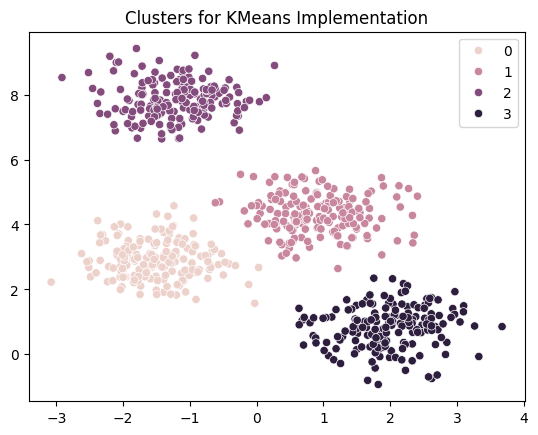

In [5]:
plot_cluster_assignments(X, hyp, 'Clusters for KMeans Implementation')

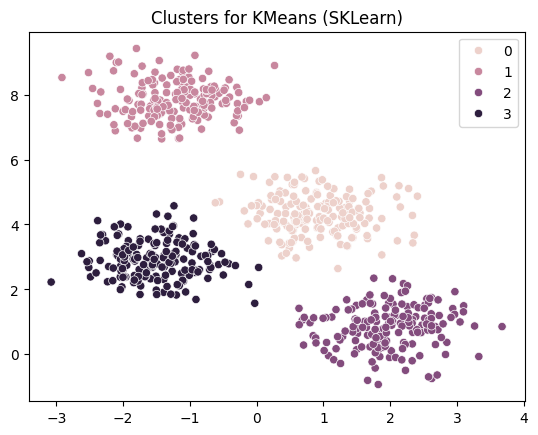

In [6]:
plot_cluster_assignments(X, sk_kmeans.labels_, 'Clusters for KMeans (SKLearn)')

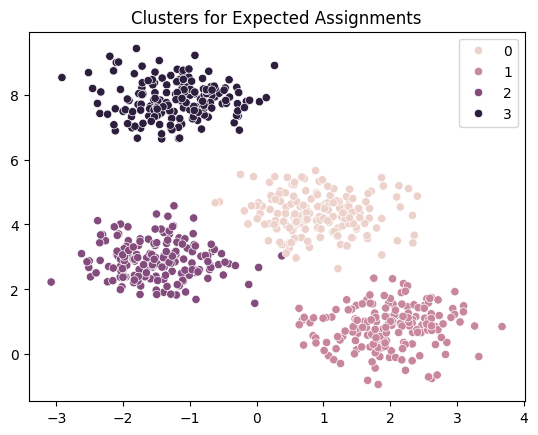

In [7]:
plot_cluster_assignments(X, cluster_assignments, 'Clusters for Expected Assignments')

# Performance Comparison

- cluster_assignments has the expected labels from generating the blobs
- hyp has the labels generated by my implementation
- sk_kmeans.labels_ has the labels generated from sklearn's KMeans

The graphs show very similar clusters but can have different numeric labels, so accuracy can be computed by grouping rows of data by clusters from one set of labels and comparing them to other groupings by a different set of labels. Taking the highest accuracy from these comparisons will be the most similar cluster to another.

### Accuracies from me vs cluster_assignments
- {0: 1.0, 1: 0.9943181818181818, 2: 1.0, 3: 1.0}
- {0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
- Conclusion: 0, 2, 3 from my clusters have an exact match to 0, 1, 3 from the cluster_assignments (not necessarily respective). Cluster 1 from me and cluster 2 from the expected are equivalent and have a 99% overlap.

### Accuracies from me vs KMeans
- {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
- {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
- Conclusion: All clusters have an exact equivalent cluster from my implementation and sklearn's KMeans.

### Accuracies from cluster_assignments vs KMeans
- {0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
- {0: 0.9943181818181818, 1: 1.0, 2: 1.0, 3: 1.0}
- Conclusion: 0, 1, 3 from cluster_assignments have an equivalent match to 1, 2, 3 from sklearn's KMeans (not necessarily respective). Cluster 2 from cluster_assignments and cluster 0 from KMeans are equivalent and have a 99% overlap.


In [8]:
def group_data_by_clusters(data, labels):
    rows_for_clusters = defaultdict(list)
    for i, k in enumerate(labels):
        rows_for_clusters[k].append(data[i])
    return rows_for_clusters

def compute_matches(data_1, data_2):
    # Lengths may not align so check for membership, [True, True] sums to 2 so use those locations to total matches
    matches = np.isin(data_1, data_2)
    full_matches = np.where(2 == np.sum(matches, axis=1))
    return len(full_matches[0]) / len(matches)

def compare_labels(data, labels_1, labels_2):
    # Create a mapping of k to the corresponding rows in cluster k for comparison by row values
    labels_1_data = group_data_by_clusters(data, labels_1)
    labels_2_data = group_data_by_clusters(data, labels_2)
    accuracies = {k: -1 for k in labels_1_data.keys()}
    
    # Cluster labels may not align, so compare all combinations and keep the highest accuracy (most matches)
    for k_1 in labels_1_data.keys():
        for k_2 in labels_2_data.keys():
            accuracies[k_1] = max(accuracies[k_1], compute_matches(labels_1_data[k_1], labels_2_data[k_2]))
    
    return accuracies

In [9]:
# Me vs cluster_assignments

# In a comparison of my implementation and the expected clusters from the make_blobs,
# we see clusters 0, 2, 3 in mine match clusters 0, 1, 3 in the expected with cluster 1-2 having a < 1% difference
pprint(compare_labels(X, hyp, cluster_assignments))
pprint(compare_labels(X, cluster_assignments, hyp))

{0: 1.0, 1: 0.9943181818181818, 2: 1.0, 3: 1.0}
{0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}


In [10]:
# Me vs KMeans

# In a comparison of my implementation and the labels from sklearn's KMeans implementation,
# we see all clusters have a complete equivalent match
pprint(compare_labels(X, hyp, sk_kmeans.labels_))
pprint(compare_labels(X, sk_kmeans.labels_, hyp))

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [11]:
# cluster_assignments vs KMeans

# In a comparison of the expected clusters from the make_blobs and the labels from sklearn's KMeans implementation,
# we see clusters 0, 1, 3 in sklearn's match clusters 1, 2, 3 in the expected with 2 and 0 having a < 1% difference
pprint(compare_labels(X, cluster_assignments, sk_kmeans.labels_))
pprint(compare_labels(X, sk_kmeans.labels_, cluster_assignments))

{0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
{0: 0.9943181818181818, 1: 1.0, 2: 1.0, 3: 1.0}


# Choose and run clustering algorithms

1. The reason why you chose the clustering algorithm(s)
- DBSCAN is good with geolocation data because it can find clusters of any shape
- It doesn't need a set number of clusters and can handle some noise (which is present with outliers in lat/long)
- Looking at the scatterplot, I thought KMeans would struggle since it's not spheroidal (rectangular strip would be split), but it does decently in terms of Silhouette Score

2. Any pre-processing of the data or any hyperparameter settings
- Normalized data in a scaler
- Did not remove outliers since there was no significant effect when pruning data outside a z-score of 3 and DBSCAN handles noise
- min_samples for DBSCAN chosen by doing the (2 * # of features) heuristic
- eps gradually increased and compared

3. Output from the algorithm(s) -- show what clusters were generated
- See graphs at below

4. The metrics you used to evaluate the output. What kind of performance did you get from that algorithm? Is that what you expected?

- I used Silhouette Score to evaluate the cluster labels. It's a measure of how well the samples are clustered with similar ones. A higher coefficient is denser with more similar intra-cluster samples and inter-cluster separation. 1 is the best, -1 is the worst, and near 0 indicates overlap.

## Chicago Taxi

### DBSCAN
- eps=0.25 has a Silhouette Score of 0.299141919587717
- eps=0.3 has a Silhouette Score of 0.2483204221879443
- eps=0.35 has a Silhouette Score of 0.5611574628181573
- eps=0.4 has a Silhouette Score of 0.551964599928041

### KMeans
- k=3 has a Silhouette Score of 0.6925622949998131
- k=4 has a Silhouette Score of 0.7031324452599282
- k=5 has a Silhouette Score of 0.7178739096946855
- k=6 has a Silhouette Score of 0.604585415756103

### Evaluation
- I gradually increased epsilon and hit a high score at epsilon=0.35 with it dropping slightly at eps=0.40. This seems like a decent score since it's far enough from 0 to show not too much cluster overlap and relatively close to 1. I think this makes sense since increasing epsilon and increasing the cluster size with more dissimilar points would lower the quality of the cluster. 
- KMeans has a better score, so even though it splits a large cluster it also groups the more sparsely points better

## Finland Mopsi

### DBSCAN
- eps=0.25 has a Silhouette Score of 0.49949188975192776
- eps=0.3 has a Silhouette Score of 0.40302791579256825
- eps=0.35 has a Silhouette Score of 0.6836709984075146
- eps=0.4 has a Silhouette Score of 0.6524095104847559
- eps=0.45 has a Silhouette Score of 0.6143517724355487
- eps=0.5 has a Silhouette Score of 0.7061283568140881

### KMeans
- k=3 has a Silhouette Score of 0.8225731079558791
- k=4 has a Silhouette Score of 0.8251275005856993
- k=5 has a Silhouette Score of 0.7342417542826452
- k=6 has a Silhouette Score of 0.8113011474258465
- k=7 has a Silhouette Score of 0.7635491873769819

### Evaluation
- I started evaluating from eps=0.25 because that's when the number of clusters and their density seemed to start being reasonable for the data. At eps=0.35 and eps=0.5 there are some clear and reasonably separated clusters. Although eps=0.5 had a better score, I think the ckusters in eps=0.35 seem strong as well since there's some high density clusters not as close to the main orange cluster at the bottom.
- KMeans had stronger scores overall despite non-spheroidal data. The clusters are reasonably dense but the boundaries are unclear.

In [4]:
df = pd.read_csv('Taxi_Trips__2013-2023_.csv')

df

Trip ID  \
0       52dc9029821e61db30a51838cb3cd711bd0e03cb   
1       11eeb6710caa0606028c7ba025bfa18c277886e8   
2       113aa7bf346c585bb941cda2d5c0015c8a1472f0   
3       2503e3944e5c82b89638447ad361638111129375   
4       23ddcfba2ad714fe0303909961ea74873be50da2   
...                                          ...   
101783  9209df4c3541198fda3173a226f2df619a806022   
101784  f0957a8f6bef37bb2872649fb3c76ad1a179acab   
101785  4cb74df671cfccceb9b592f347ef1a94c1540c7a   
101786  7f24c5101df65952ef318f558b8b071989ff7c17   
101787  1f64a83220a6df1917fe617cca37f155d6f477ff   

                                                  Taxi ID  \
0       275f3f891b8c0ba8f2958873f850d2a03993c99f5f79f6...   
1       6c87f1d023a9d7146ae81b6aa4648bf98cec52cceb9f08...   
2       bb4e75d3065311c33024a434640731c43fd2cf9e4482eb...   
3       57c40509cae37a0e5e536a657cdb7f8c6824314bc466a7...   
4       40720025b84fa778c47d6637db01b1d8f2de2eabafa529...   
...                                                   ...   
101783  dee6032433df09fe8d3fd4fa958380308c902dc98f81c3...   
101784  3f6562a2a18861cf21a21101c14cc91dd7c4d72cdce80f...   
101785  b31f46efa11263565e3dba91f26ff96b74516e8108ac56...   
101786  65057dc10e707a18a32bc4371c5db0b828e90f9caf1068...   
101787  67cdd41437563bed53a4348a0a050d03bfb80df4cc2519...   

          Trip Start Timestamp      Trip End Timestamp  Trip Seconds  \
0       02/01/2023 12:15:00 AM  02/01/2023 12:30:00 AM        1140.0   
1       02/01/2023 12:15:00 AM  02/01/2023 12:15:00 AM         660.0   
2       02/01/2023 12:15:00 AM  02/01/2023 12:30:00 AM         480.0   
3       02/01/2023 12:15:00 AM  02/01/2023 12:45:00 AM        1620.0   
4       02/01/2023 12:15:00 AM  02/01/2023 12:15:00 AM         360.0   
...                        ...                     ...           ...   
101783  02/07/2023 11:45:00 PM  02/07/2023 11:45:00 PM         760.0   
101784  02/07/2023 11:45:00 PM  02/07/2023 11:45:00 PM           4.0   
101785  02/14/2023 10:30:00 AM  02/14/2020 06:00:00 PM           NaN   
101786  04/27/2023 11:15:00 AM  04/21/2019 09:30:00 PM           NaN   
101787  12/13/2023 03:00:00 PM  09/29/2011 04:45:00 PM           NaN   

        Trip Miles  Pickup Census Tract  Dropoff Census Tract  \
0            11.20                  NaN                   NaN   
1             2.70                  NaN                   NaN   
2             0.00                  NaN                   NaN   
3             0.00         1.703198e+10                   NaN   
4             0.10                  NaN                   NaN   
...            ...                  ...                   ...   
101783        2.69         1.703183e+10          1.703132e+10   
101784        0.00                  NaN                   NaN   
101785        2.90                  NaN                   NaN   
101786       15.10                  NaN                   NaN   
101787       13.20                  NaN                   NaN   

        Pickup Community Area  Dropoff Community Area  ...  Extras  \
0                        76.0                     NaN  ...    21.0   
1                        32.0                     7.0  ...     0.0   
2                         8.0                    24.0  ...     0.0   
3                        76.0                     NaN  ...    28.0   
4                        76.0                     NaN  ...     4.0   
...                       ...                     ...  ...     ...   
101783                   28.0                    32.0  ...     0.0   
101784                    8.0                     8.0  ...     0.0   
101785                    8.0                    24.0  ...     0.0   
101786                   76.0                     7.0  ...     4.0   
101787                    NaN                     NaN  ...     7.0   

        Trip Total  Payment Type                        Company  \
0            49.75          Cash   4053 - 40193 Adwar H. Nikola   
1            13.00   Credit Card      Taxi Affiliation Service

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101788 entries, 0 to 101787
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Trip ID                     101788 non-null  object 
 1   Taxi ID                     101779 non-null  object 
 2   Trip Start Timestamp        101788 non-null  object 
 3   Trip End Timestamp          101788 non-null  object 
 4   Trip Seconds                101763 non-null  float64
 5   Trip Miles                  101788 non-null  float64
 6   Pickup Census Tract         35179 non-null   float64
 7   Dropoff Census Tract        35054 non-null   float64
 8   Pickup Community Area       95650 non-null   float64
 9   Dropoff Community Area      92192 non-null   float64
 10  Fare                        101681 non-null  float64
 11  Tips                        101681 non-null  float64
 12  Tolls                       101681 non-null  float64
 13  Extras        

In [6]:
df.describe()

# Trip seconds/miles starts at 0, is non-normal

Trip Seconds     Trip Miles  Pickup Census Tract  \
count  101763.000000  101788.000000         3.517900e+04   
mean     1102.644891       6.021135         1.703149e+10   
std      1831.031101       7.572349         3.696445e+05   
min         0.000000       0.000000         1.703101e+10   
25%       420.000000       0.870000         1.703108e+10   
50%       836.000000       2.600000         1.703132e+10   
75%      1516.000000      10.800000         1.703184e+10   
max     86003.000000     814.300000         1.703198e+10   

       Dropoff Census Tract  Pickup Community Area  Dropoff Community Area  \
count          3.505400e+04           95650.000000            92192.000000   
mean           1.703140e+10              33.230946               25.300764   
std            3.377955e+05              25.309183               20.270499   
min            1.703101e+10               1.000000                1.000000   
25%            1.703108e+10               8.000000                8.000000   
50%            1.703132e+10              32.000000               28.000000   
75%            1.703184e+10              50.000000               32.000000   
max            1.703198e+10              77.000000               77.000000   

                Fare           Tips          Tolls         Extras  \
count  101681.000000  101681.000000  101681.000000  101681.000000   
mean       20.466054       2.452347       0.014503       1.679117   
std        18.103452       3.918353       0.602782       5.208910   
min         0.000000       0.000000       0.000000       0.000000   
25%         7.750000       0.000000       0.000000       0.000000   
50%        13.500000       0.000000       0.000000       0.000000   
75%        31.000000       3.000000       0.000000       1.000000   
max       999.000000     250.000000      78.000000     182.000000   

          Trip Total  Pickup Centroid Latitude  Pickup Centroid Longitude  \
count  101681.000000              95657.000000               95657.000000   
mean       24.739358                 41.898703                 -87.689956   
std        22.641634                  0.064621                   0.104274   
min         0.000000                 41.660136                 -87.913625   
25%         9.500000                 41.878866                 -87.695013   
50%        16.000000                 41.895033                 -87.642649   
75%        33.900000                 41.949829                 -87.626211   
max       999.000000                 42.015934                 -87.534903   

       Dropoff Centroid Latitude  Dropoff Centroid Longitude  
count               92489.000000                92489.000000  
mean                   41.892116                  -87.657546  
std                     0.059306                    0.063430  
min                    41.660136                  -87.913625  
25%                    41.878866                  -87.663518  
50%                    41.892508                  -87.633308  
75%                    41.922686                  -87.625192  
max                    42.021224                  -87.534903

array([[<Axes: title={'center': 'Trip Seconds'}>,
        <Axes: title={'center': 'Trip Miles'}>,
        <Axes: title={'center': 'Pickup Census Tract'}>,
        <Axes: title={'center': 'Dropoff Census Tract'}>],
       [<Axes: title={'center': 'Pickup Community Area'}>,
        <Axes: title={'center': 'Dropoff Community Area'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Tips'}>],
       [<Axes: title={'center': 'Tolls'}>,
        <Axes: title={'center': 'Extras'}>,
        <Axes: title={'center': 'Trip Total'}>,
        <Axes: title={'center': 'Pickup Centroid Latitude'}>],
       [<Axes: title={'center': 'Pickup Centroid Longitude'}>,
        <Axes: title={'center': 'Dropoff Centroid Latitude'}>,
        <Axes: title={'center': 'Dropoff Centroid Longitude'}>, <Axes: >]],
      dtype=object)

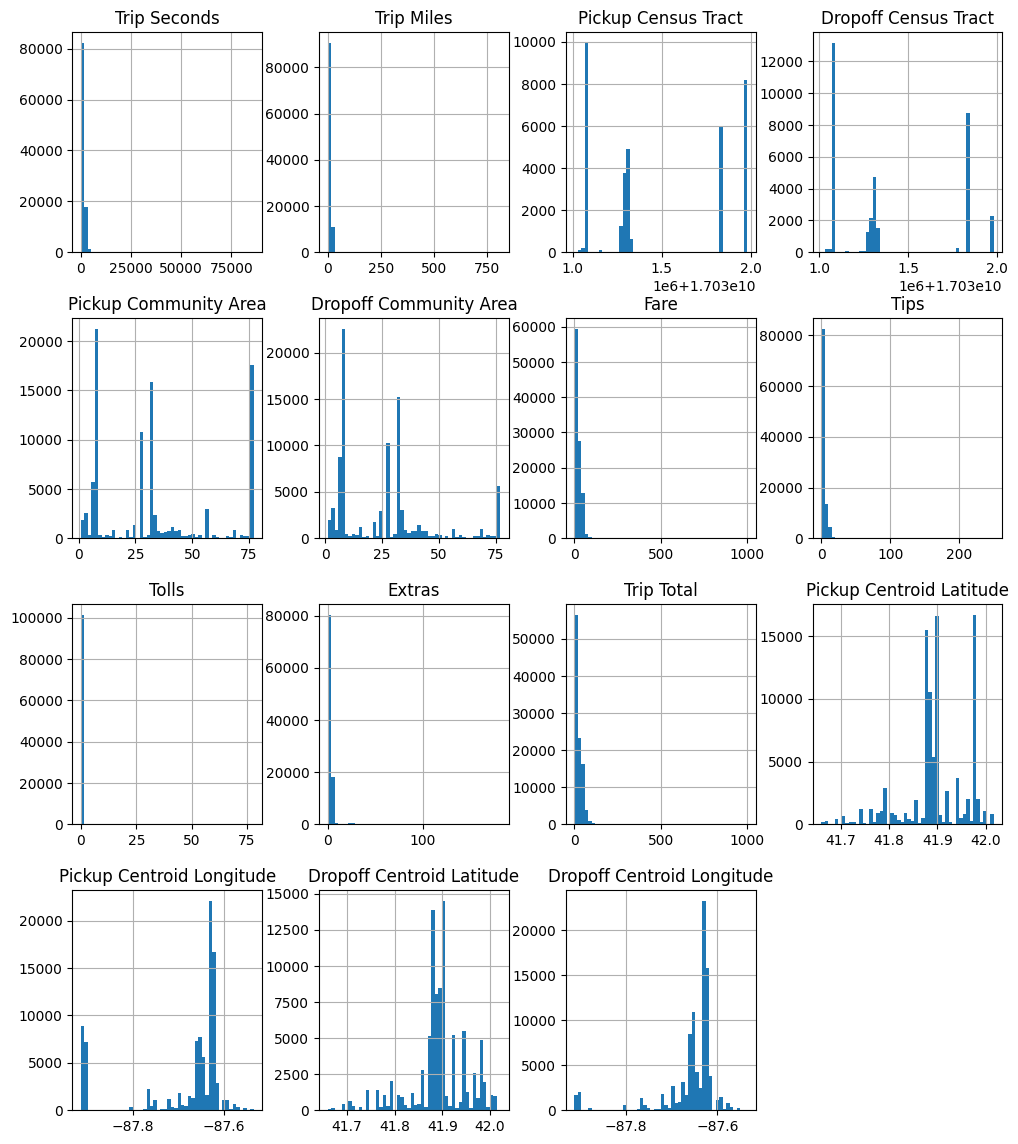

In [87]:
df.hist(bins=50, figsize=(12,14))

<Axes: ylabel='Pickup Centroid Latitude'>

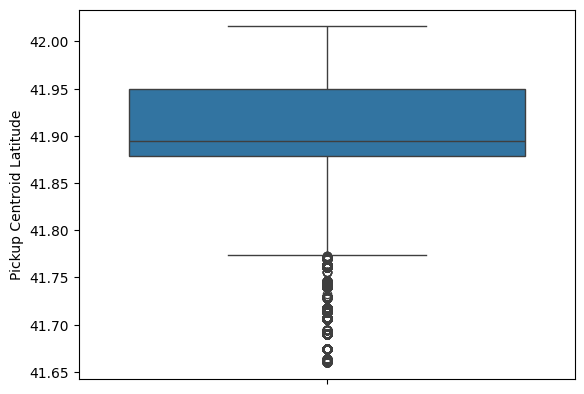

In [7]:
sns.boxplot(data=df['Pickup Centroid Latitude'])

<Axes: ylabel='Pickup Centroid Longitude'>

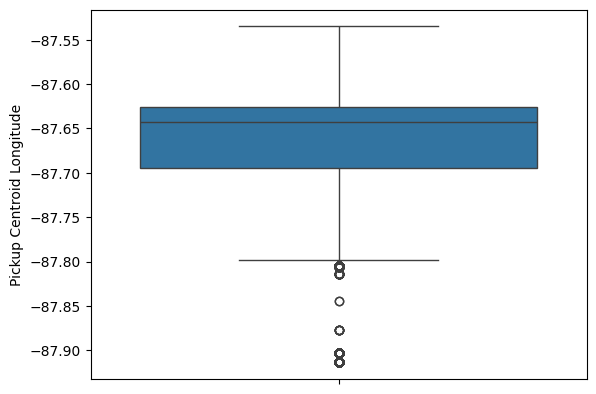

In [8]:
sns.boxplot(data=df['Pickup Centroid Longitude'])

<Axes: xlabel='Pickup Centroid Longitude', ylabel='Pickup Centroid Latitude'>

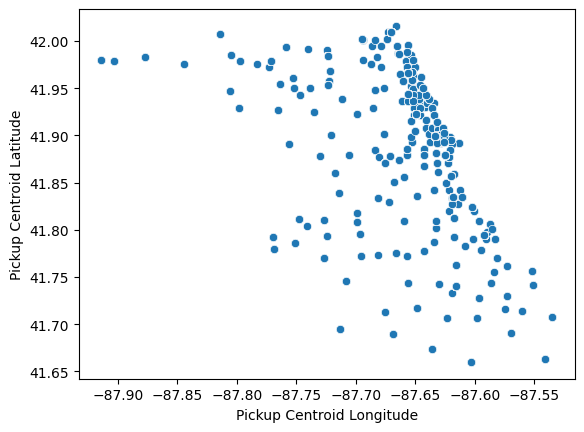

In [9]:
sns.scatterplot(x=df['Pickup Centroid Longitude'], y=df['Pickup Centroid Latitude'])

<Axes: >

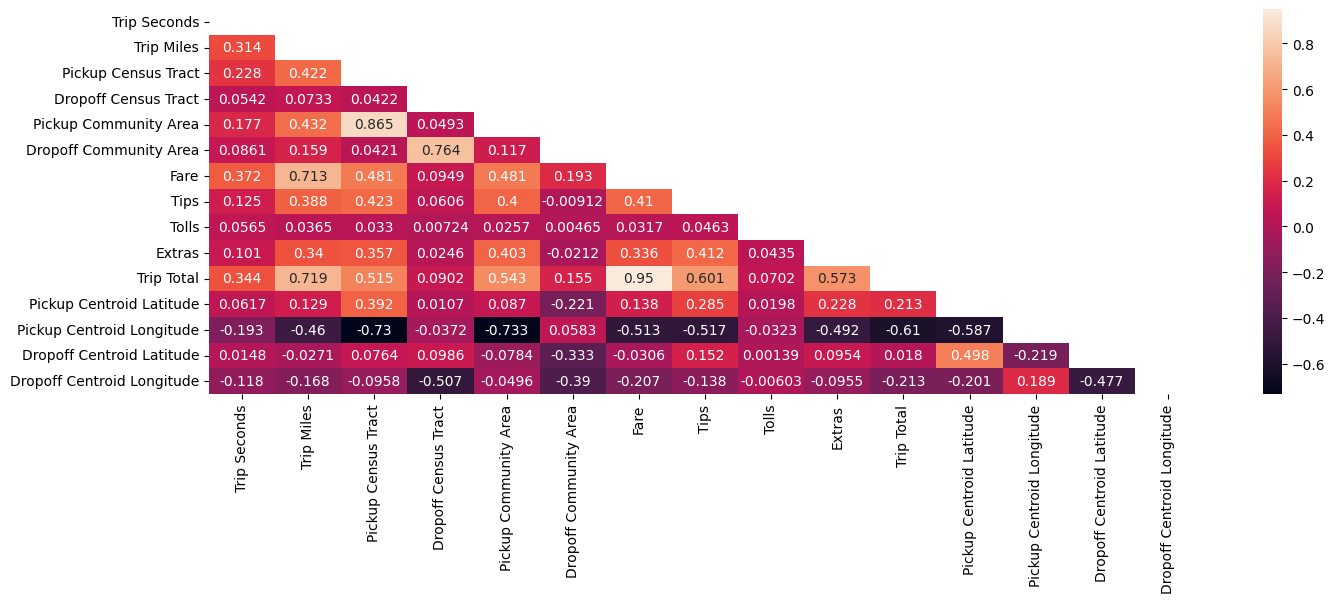

In [95]:
corr = df.corr(numeric_only=True)
plt.figure(figsize = (16,5))
sns.heatmap(corr, annot=True, mask=np.triu(corr), fmt='.3')

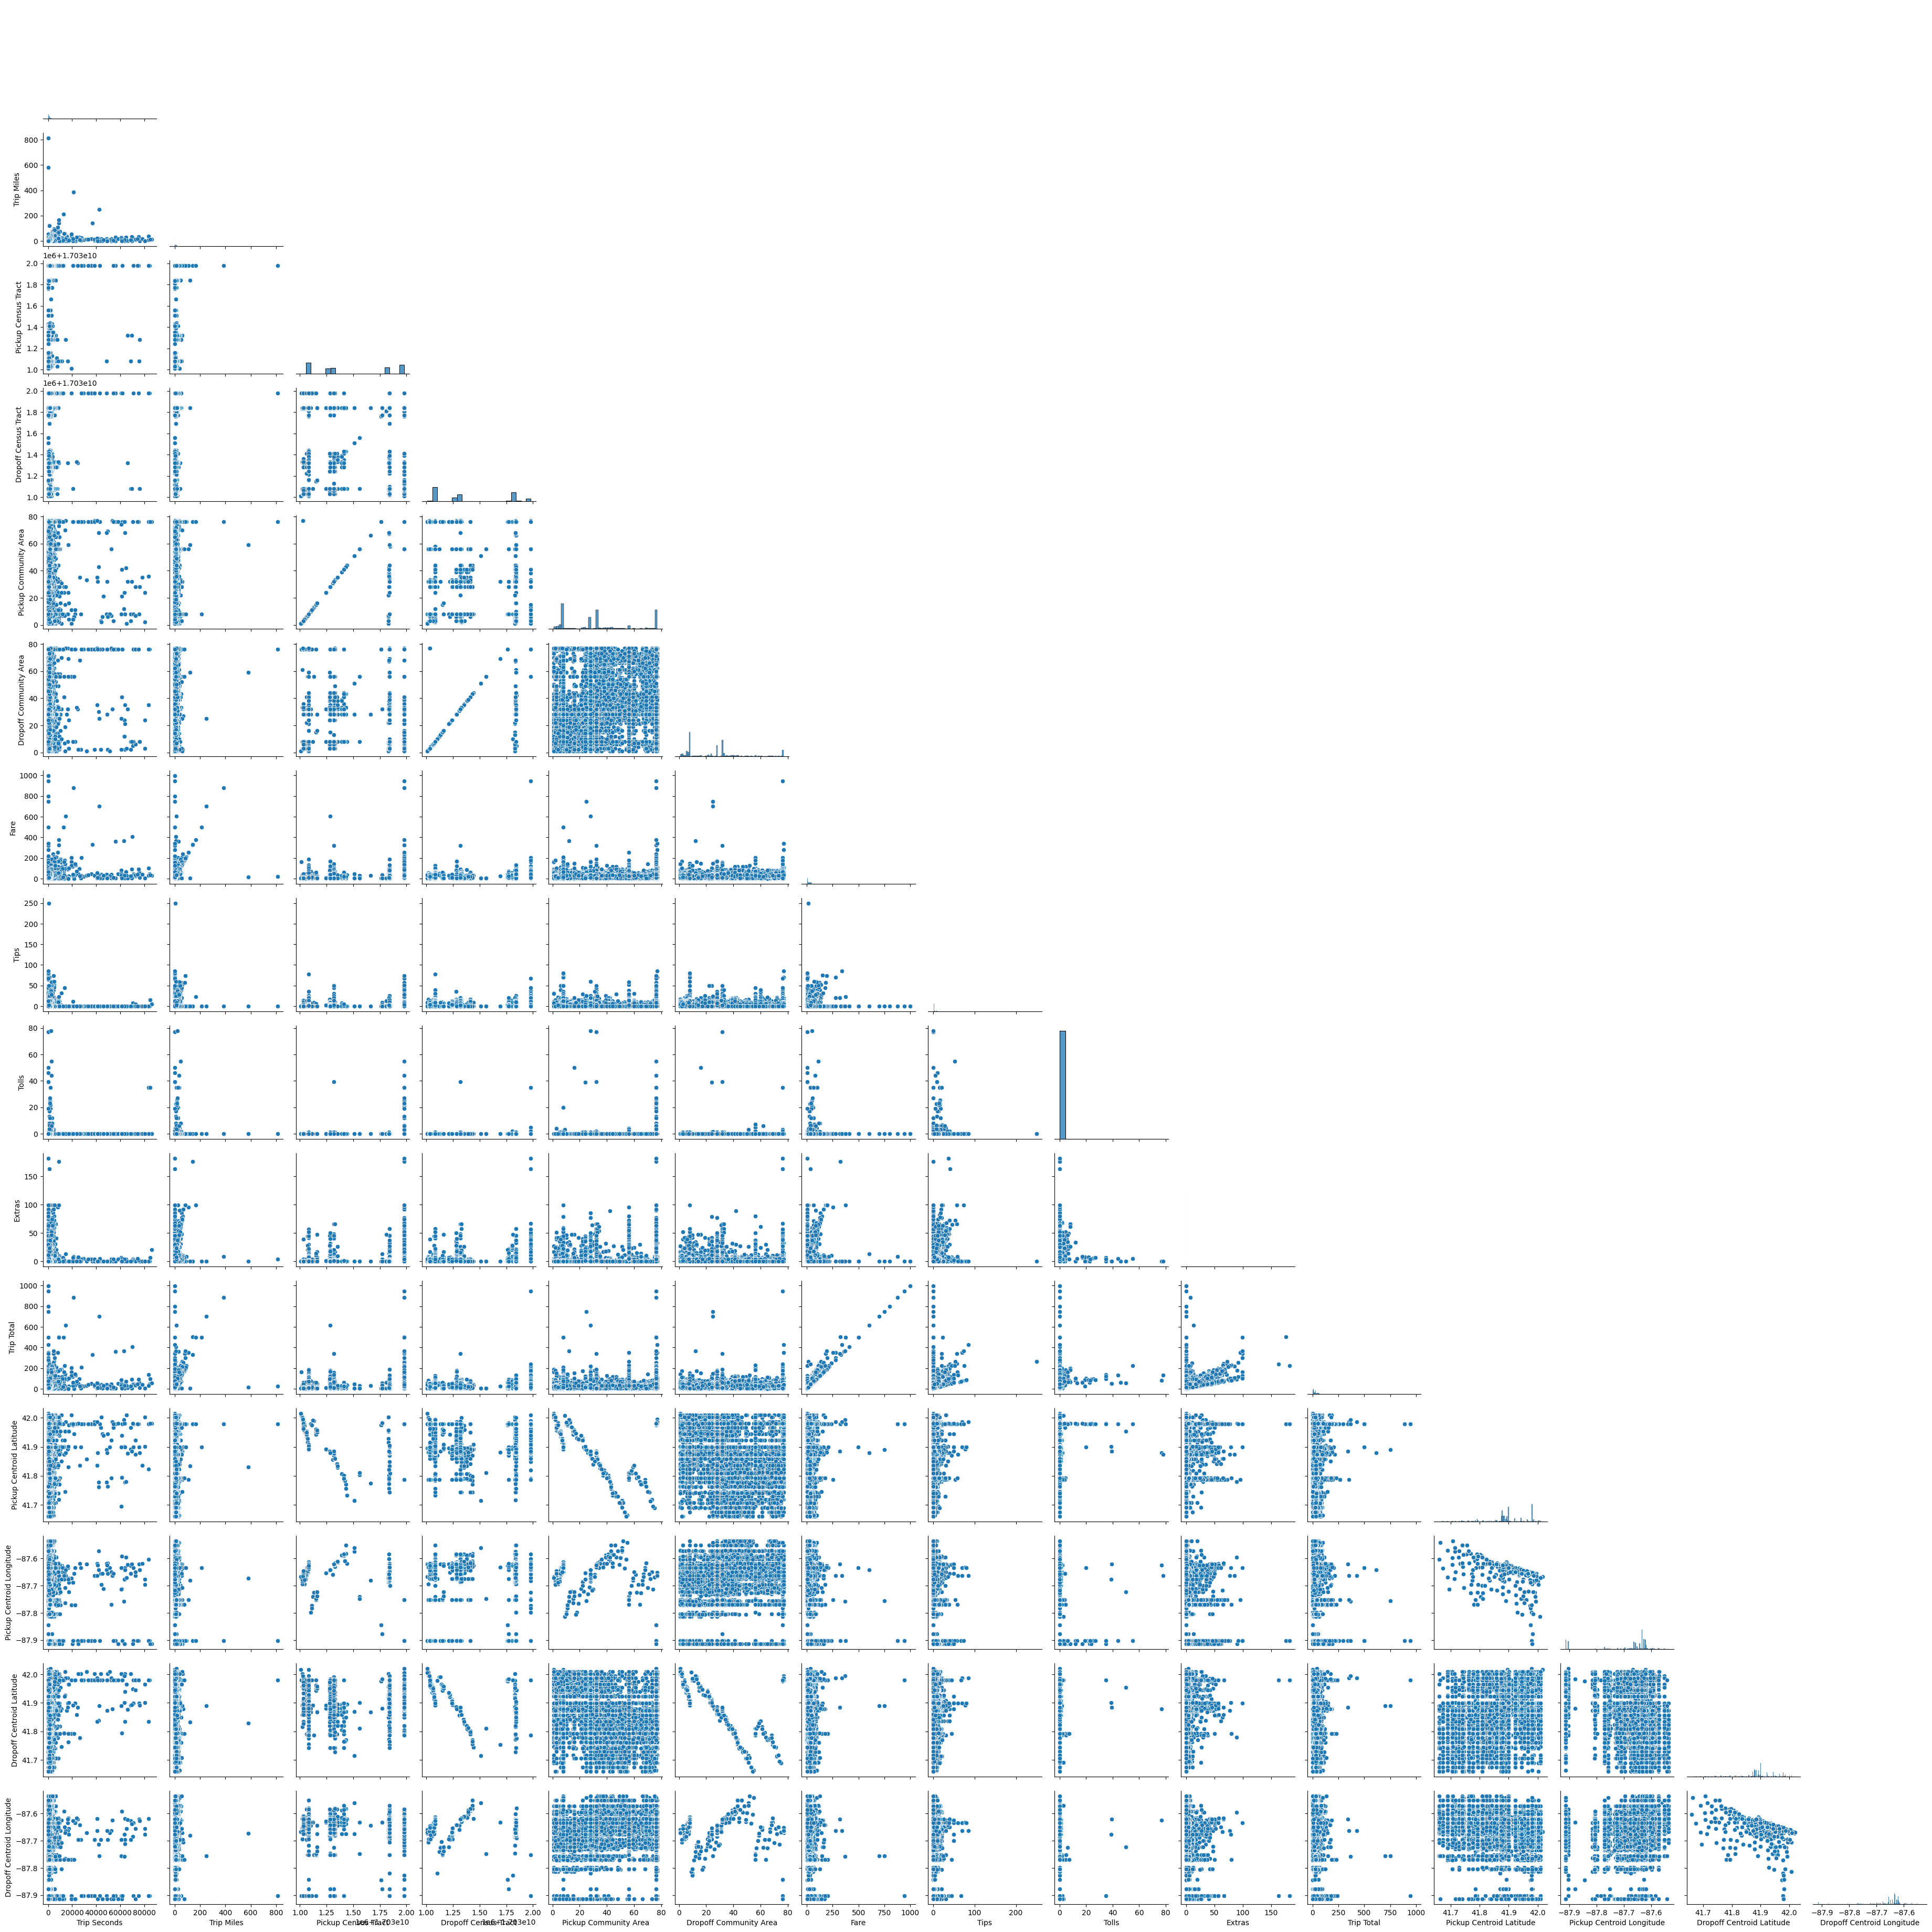

In [88]:
sns.pairplot(df, corner=True)

# Data Quality Report (Chicago)

- There are many null data points
- Census Tracts not all accounted for because: "For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago."
- The Community Area and Latitude/Longitude rows are also missing data (not explicitly explained in the original data)
- Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total are all power law distributed
- The spikes in latitude/longitude are likely near important points of interest in the city
- There are some strong positive correlations for Fare->Trip Total, Trip Miles->Trip Total and Fare, and the pickup area to its latitude/longitude
- There are some weak positive correlations for Trip Miles->Extras and Tips
- There are some outliers for latitude/longitude but they do not significantly affect the clustering after normalization. I compared the models by pruning data outside a z-score range of 3 and had no notable changes

In [5]:
pickup_df = df[['Pickup Centroid Longitude', 'Pickup Centroid Latitude']]
pickup_df = pickup_df.dropna()

scaler = StandardScaler()
scaler.fit(pickup_df)
normalized_data = scaler.transform(pickup_df)

In [6]:
normalized_data

array([[-2.14503019,  1.26216408],
       [ 0.62109854, -0.30698521],
       [ 0.54326538,  0.01391335],
       ...,
       [ 0.54326538,  0.01391335],
       [ 0.54326538,  0.01391335],
       [-2.14503019,  1.26216408]])

In [58]:
def plot_clusters(data, eps=0.5, min_samples=44, is_dbscan=True, k=5, color="tab10", figsize=(12.0, 7.0)):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data) if is_dbscan else KMeans(n_clusters=k).fit(data)
    plt.figure(figsize=figsize)
    sns.scatterplot(x=data[:, 0],
                    y=data[:, 1],
                    hue=clustering.labels_,
                    palette=color
                    )
    return clustering.labels_

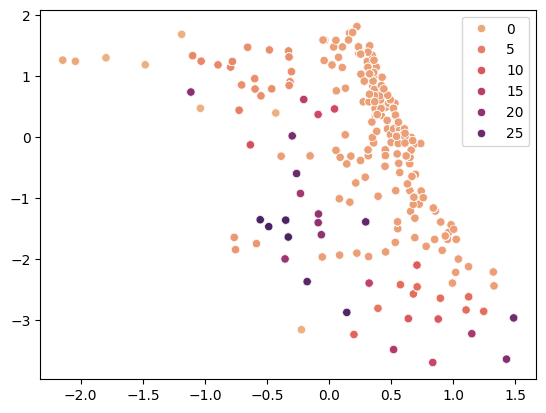

In [9]:
cluster_25 = plot_clusters(normalized_data, eps=.25, color=sns.color_palette("flare", as_cmap=True))

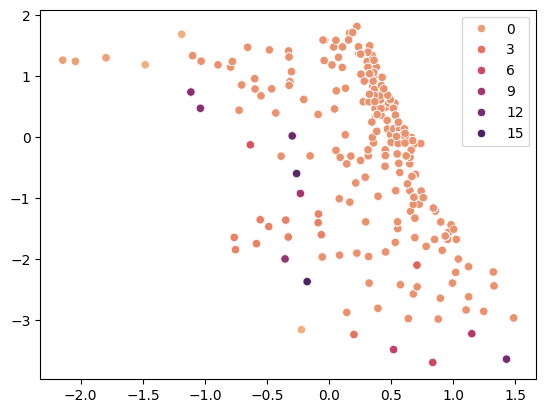

In [10]:
cluster_30 = plot_clusters(normalized_data, eps=.30, color=sns.color_palette("flare", as_cmap=True))

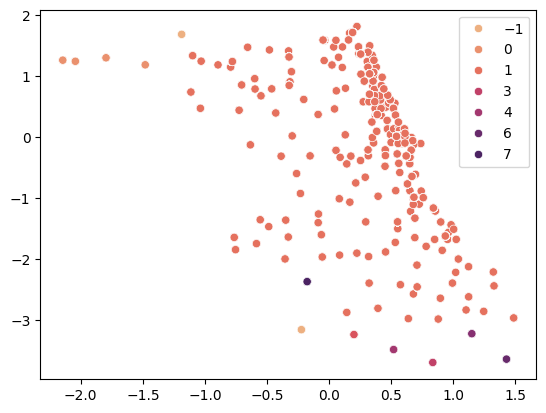

In [11]:
cluster_35 = plot_clusters(normalized_data, eps=.35, color=sns.color_palette("flare", as_cmap=True))

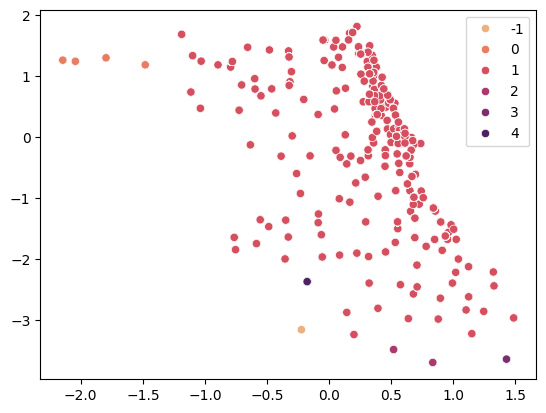

In [12]:
cluster_40 = plot_clusters(normalized_data, eps=.40, color=sns.color_palette("flare", as_cmap=True))

In [27]:
cluster_labels = [(.25, cluster_25), (.30, cluster_30), (.35, cluster_35), (.40, cluster_40)]

for eps, label in cluster_labels:
    print(f'{eps=} has a Silhouette Score of {silhouette_score(normalized_data, label)}')

eps=0.25 has a Silhouette Score of 0.299141919587717
eps=0.3 has a Silhouette Score of 0.2483204221879443
eps=0.35 has a Silhouette Score of 0.5611574628181573
eps=0.4 has a Silhouette Score of 0.551964599928041


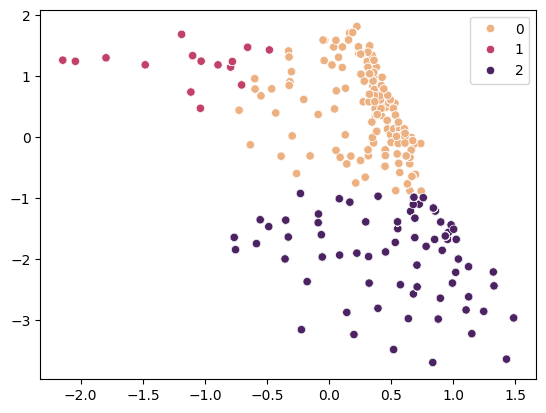

In [14]:
kmeans_3 = plot_clusters(normalized_data, is_dbscan=False, k=3, color=sns.color_palette("flare", as_cmap=True))

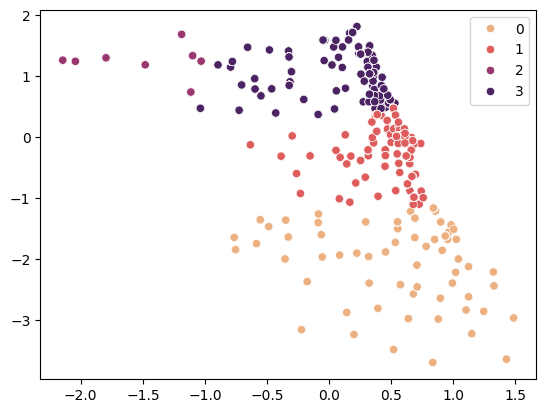

In [15]:
kmeans_4 = plot_clusters(normalized_data, is_dbscan=False, k=4, color=sns.color_palette("flare", as_cmap=True))

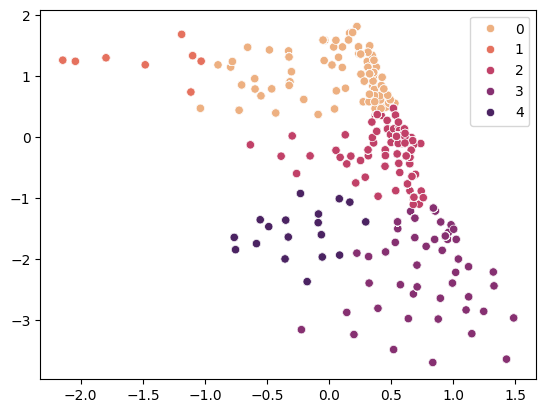

In [16]:
kmeans_5 = plot_clusters(normalized_data, is_dbscan=False, k=5, color=sns.color_palette("flare", as_cmap=True))

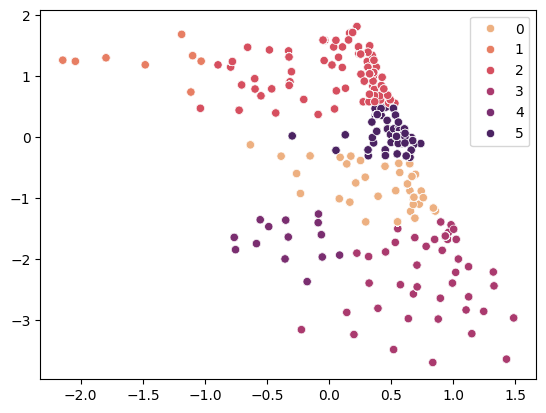

In [18]:
kmeans_6 = plot_clusters(normalized_data, is_dbscan=False, k=6, color=sns.color_palette("flare", as_cmap=True))

In [19]:
kmeans_cluster_labels = [(3, kmeans_3), (4, kmeans_4), (5, kmeans_5), (6, kmeans_6)]

for k, label in kmeans_cluster_labels:
    print(f'{k=} has a Silhouette Score of {silhouette_score(normalized_data, label)}')

k=3 has a Silhouette Score of 0.6925622949998131
k=4 has a Silhouette Score of 0.7031324452599282
k=5 has a Silhouette Score of 0.7178739096946855
k=6 has a Silhouette Score of 0.604585415756103


## Finland Mopsi Data

In [38]:
df_mopsi = pd.read_csv('MopsiLocationsUntil2012-Finland.txt', sep='\t', header=None)

df_mopsi = df_mopsi.rename(columns={0: 'Latitude', 1: 'Longitude'})
df_mopsi = df_mopsi/10_000
df_mopsi = df_mopsi[df_mopsi.columns.tolist()[::-1]]
df_mopsi

Longitude  Latitude
0        29.7439   62.5983
1        29.7440   62.6146
2        29.7456   62.6144
3        29.7394   62.6004
4        29.7437   62.6018
...          ...       ...
13462    29.7444   62.6042
13463    29.7443   62.5977
13464    29.7404   62.6050
13465    29.7426   62.5995
13466    29.7431   62.5982

[13467 rows x 2 columns]

In [39]:
df_mopsi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13467 entries, 0 to 13466
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  13467 non-null  float64
 1   Latitude   13467 non-null  float64
dtypes: float64(2)
memory usage: 210.5 KB


In [40]:
df_mopsi.describe()

Longitude      Latitude
count  13467.000000  13467.000000
mean      28.900467     62.509478
std        2.039943      0.784433
min       21.201600     59.924700
25%       29.616400     62.593000
50%       29.744800     62.601800
75%       29.779650     62.619200
max       31.432800     69.783500

array([[<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Latitude'}>]], dtype=object)

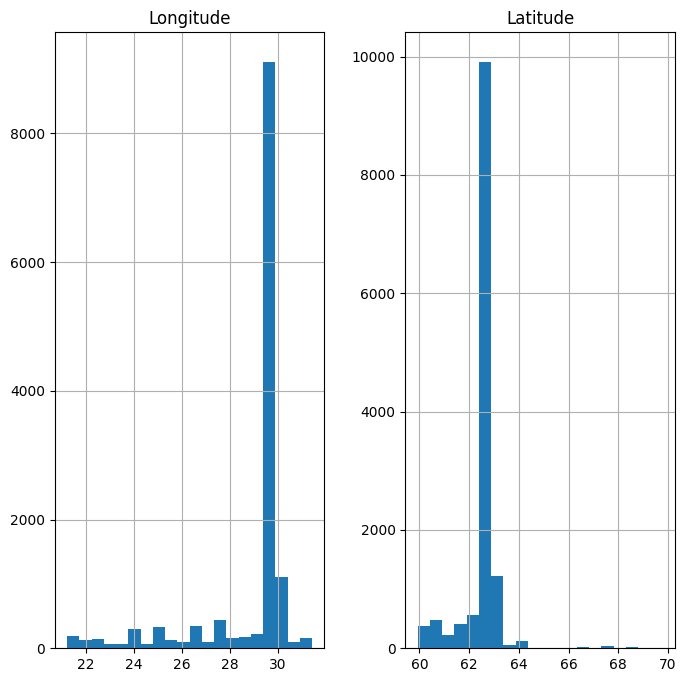

In [41]:
df_mopsi.hist(bins=20, figsize=(8, 8))

<Axes: xlabel='Longitude', ylabel='Latitude'>

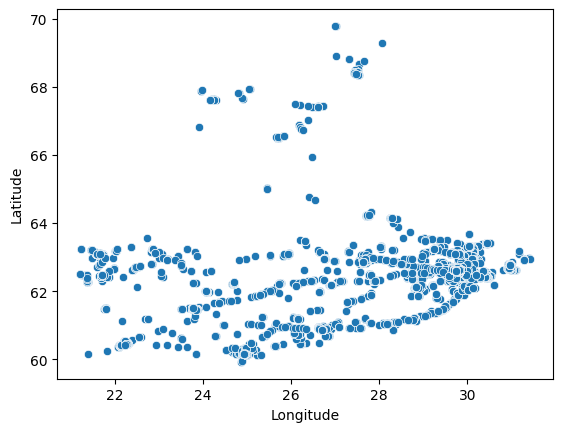

In [42]:
sns.scatterplot(x=df_mopsi.Longitude, y=df_mopsi.Latitude)

# Data Quality Report (Mopsi)

- Originally came as unlabelled data in 2 columns
- Originally came as large numbers
- After looking at related data from Mopsi, I determined it was latitude/longitude and in the wrong format
- Latitude/Longituide values are obtained by dividing by 10,000 to shift the decimal
- I swapped the position of the columns to reflect an (x,y) relationship to make the plots easier

In [43]:
scaler = StandardScaler()
scaler.fit(df_mopsi)
normalized_mopsi_data = scaler.transform(df_mopsi)

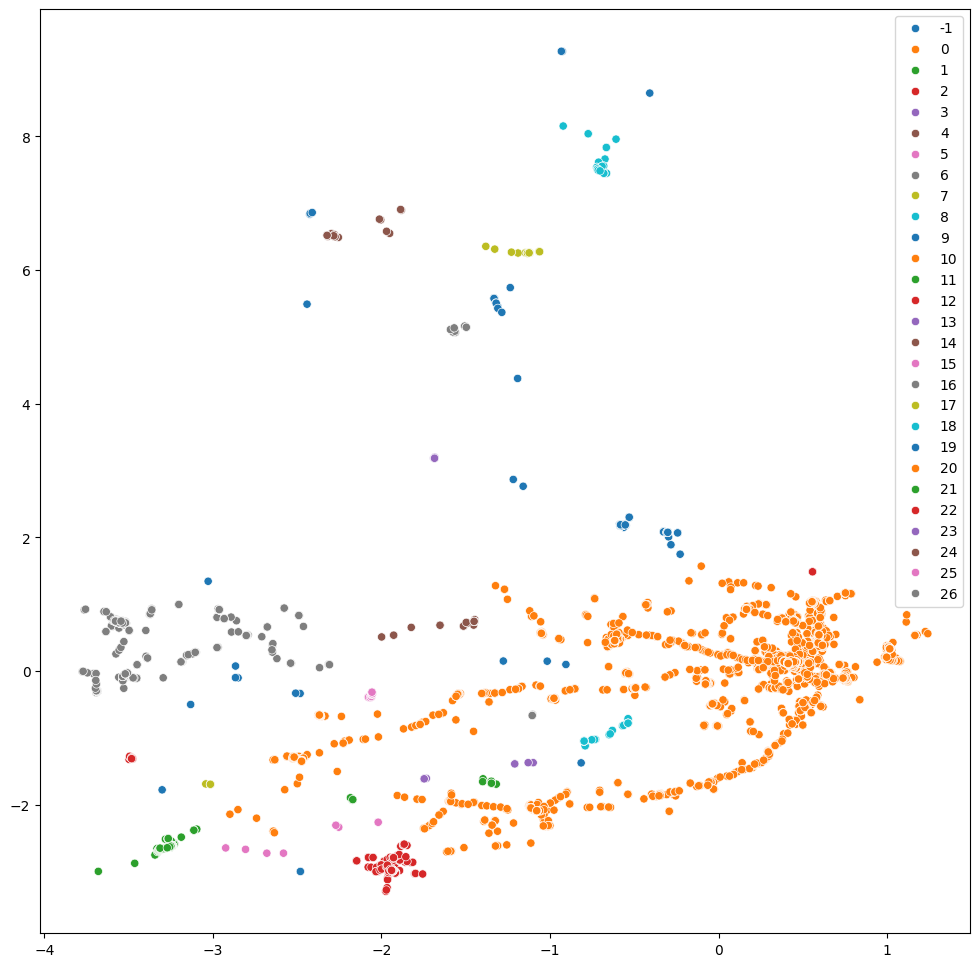

In [59]:
mopsi_eps_25 = plot_clusters(normalized_mopsi_data, eps=.25, min_samples=4, figsize=(12, 12))

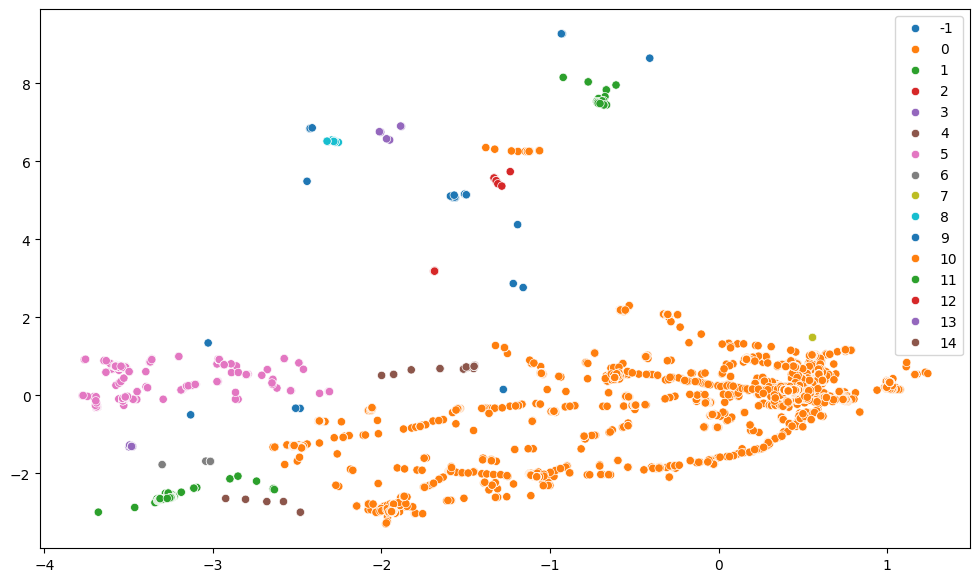

In [60]:
mopsi_eps_30 = plot_clusters(normalized_mopsi_data, eps=.30, min_samples=4)

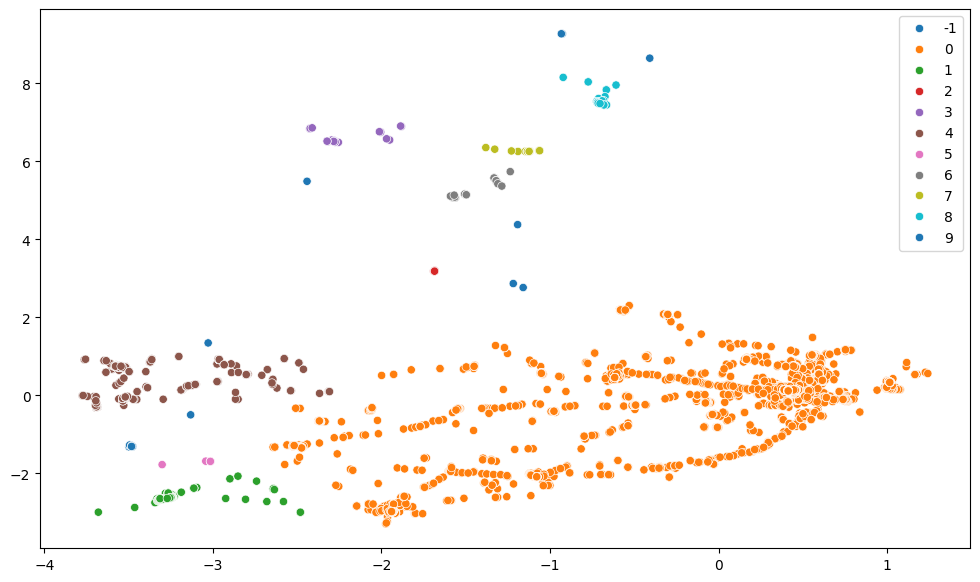

In [61]:
mopsi_eps_35 = plot_clusters(normalized_mopsi_data, eps=.35, min_samples=4)

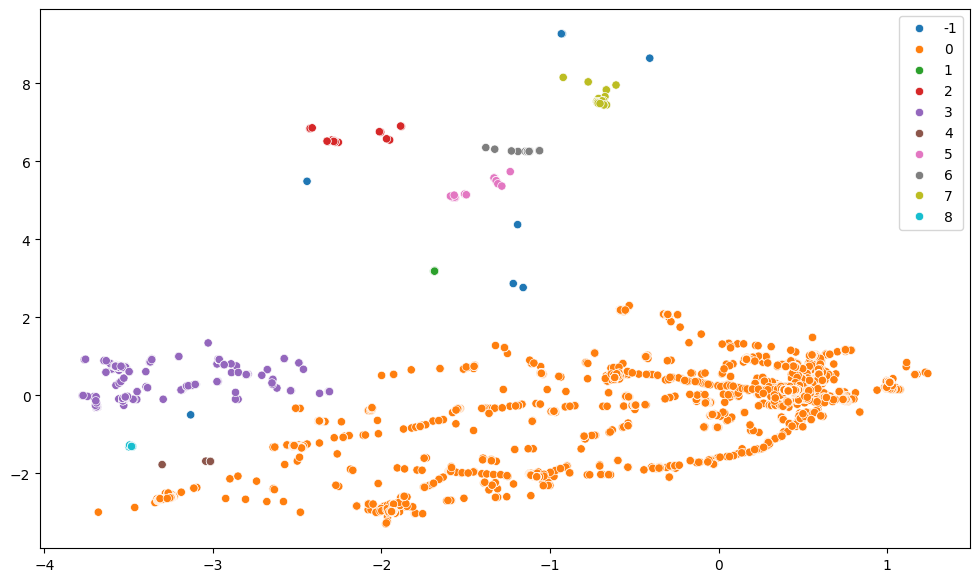

In [62]:
mopsi_eps_40 = plot_clusters(normalized_mopsi_data, eps=.40, min_samples=4)

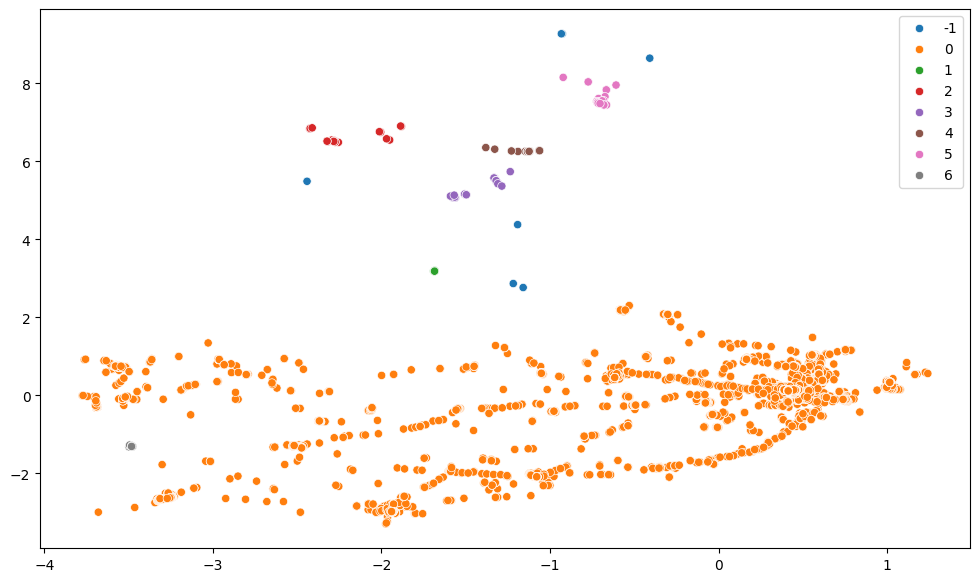

In [63]:
mopsi_eps_45 = plot_clusters(normalized_mopsi_data, eps=.45, min_samples=4)

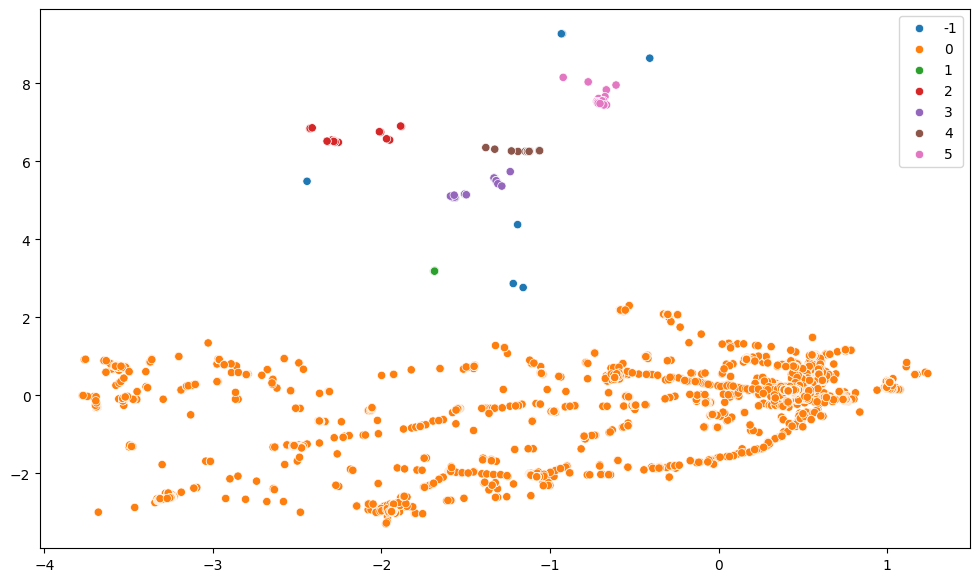

In [64]:
mopsi_eps_50 = plot_clusters(normalized_mopsi_data, eps=.50, min_samples=4)

In [76]:
mopsi_clusters = [(.25, mopsi_eps_25), (.30, mopsi_eps_30), (.35, mopsi_eps_35), (.40, mopsi_eps_40),
                  (.45, mopsi_eps_45), (.50, mopsi_eps_50)]

for eps, label in mopsi_clusters:
    print(f'{eps=} has a Silhouette Score of {silhouette_score(normalized_mopsi_data, label)}')

eps=0.25 has a Silhouette Score of 0.49949188975192776
eps=0.3 has a Silhouette Score of 0.40302791579256825
eps=0.35 has a Silhouette Score of 0.6836709984075146
eps=0.4 has a Silhouette Score of 0.6524095104847559
eps=0.45 has a Silhouette Score of 0.6143517724355487
eps=0.5 has a Silhouette Score of 0.7061283568140881


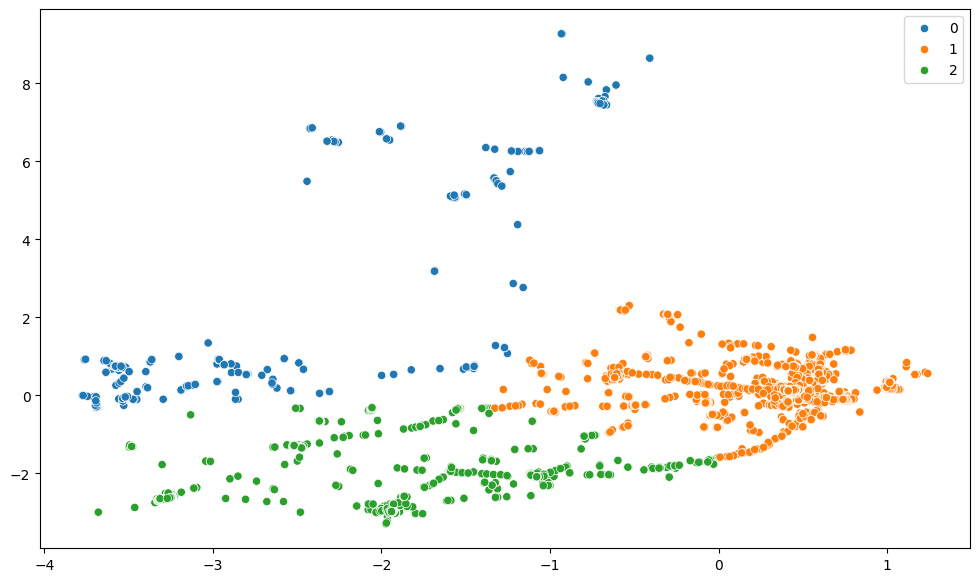

In [77]:
mopsi_kmeans_3 = plot_clusters(normalized_mopsi_data, is_dbscan=False, k=3)

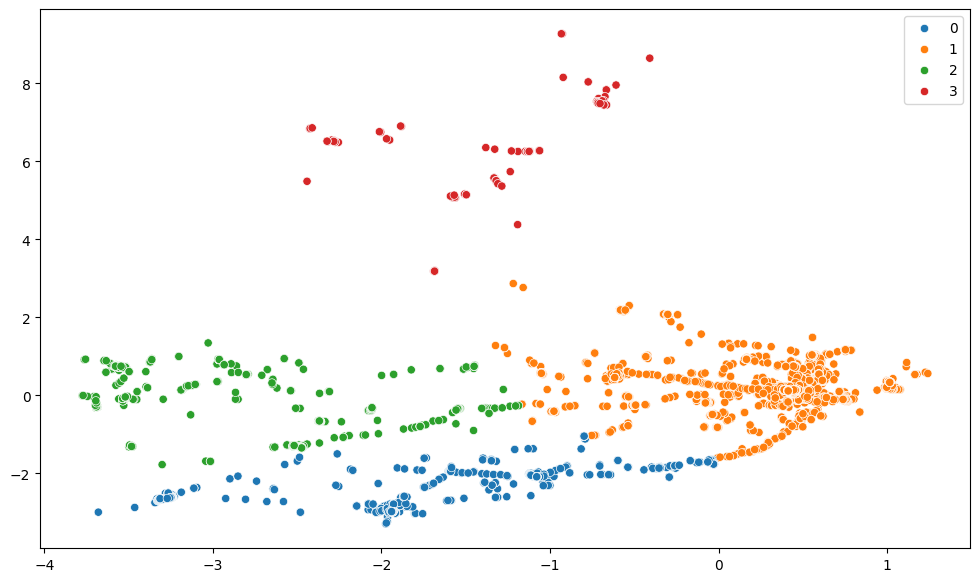

In [78]:
mopsi_kmeans_4 = plot_clusters(normalized_mopsi_data, is_dbscan=False, k=4)

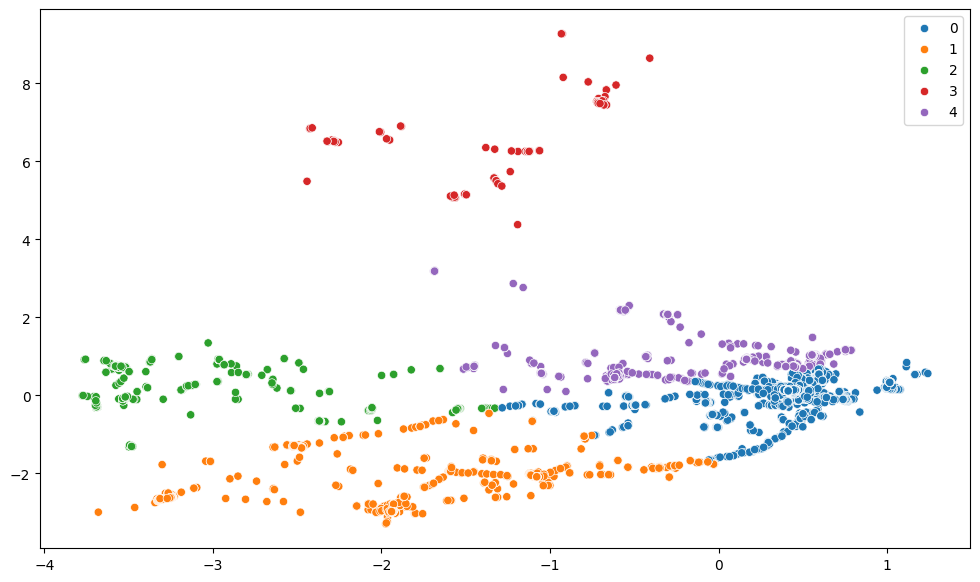

In [79]:
mopsi_kmeans_5 = plot_clusters(normalized_mopsi_data, is_dbscan=False, k=5)

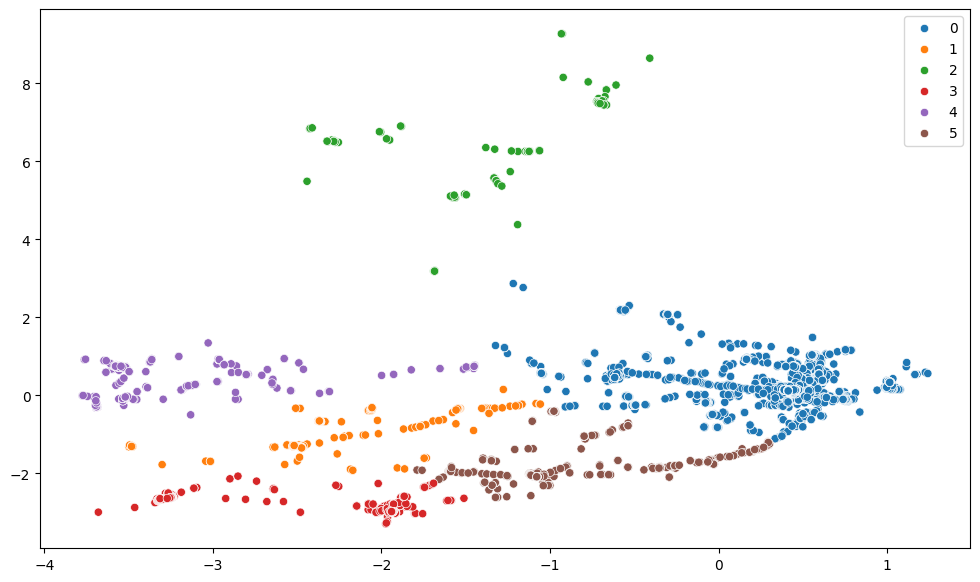

In [80]:
mopsi_kmeans_6 = plot_clusters(normalized_mopsi_data, is_dbscan=False, k=6)

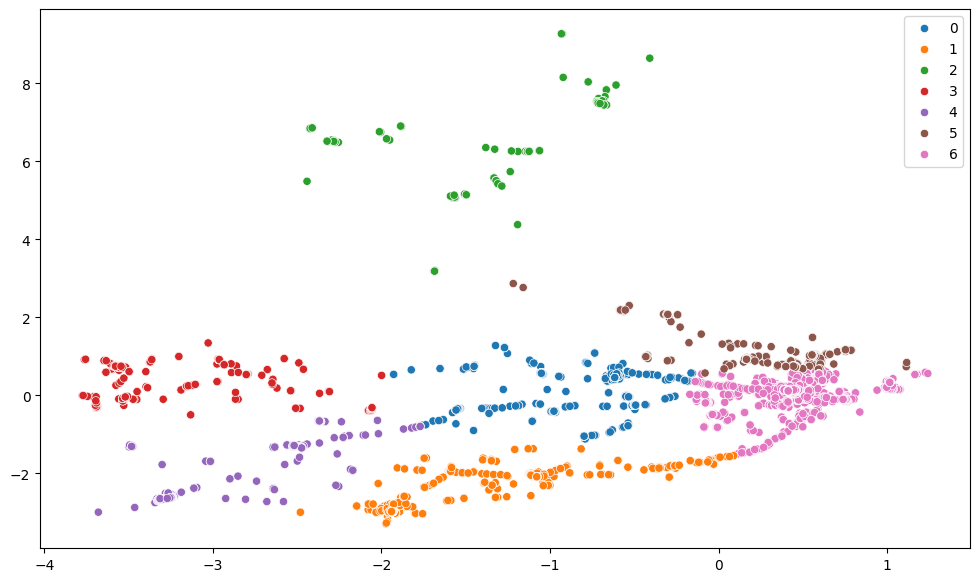

In [81]:
mopsi_kmeans_7 = plot_clusters(normalized_mopsi_data, is_dbscan=False, k=7)

In [82]:
mopsi_kmeans_clusters = [(3, mopsi_kmeans_3), (4, mopsi_kmeans_4), (5, mopsi_kmeans_5), (6, mopsi_kmeans_6),
                        (7, mopsi_kmeans_7)]

for k, label in mopsi_kmeans_clusters:
    print(f'{k=} has a Silhouette Score of {silhouette_score(normalized_mopsi_data, label)}')

k=3 has a Silhouette Score of 0.8225731079558791
k=4 has a Silhouette Score of 0.8251275005856993
k=5 has a Silhouette Score of 0.7342417542826452
k=6 has a Silhouette Score of 0.8113011474258465
k=7 has a Silhouette Score of 0.7635491873769819
